In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline
import glob
import natsort

In [2]:
print(cv2. __version__)

4.6.0


In [3]:
def get_background(frame,images):
# getting shape of the frame to create background
    row,col = frame.shape
    background = np.zeros([row,col],np.uint8) #All black image
    background = np.median(images,axis=0) #bg
    background = background.astype(np.uint8) # by median openration data type of background changes so again change it to uint8
    bg = background.copy()
    bg = cv2.cvtColor(bg, cv2.COLOR_GRAY2RGB)
    plt.imshow(bg)
    return background

def get_foreground_objects(img,background,threshold):
    res = cv2.absdiff(img,background)
    c,d = res.shape
    for i in range(c):
        for j in range(d):
            if res[i][j] > threshold:
                res[i][j] = 255
            else:
                res[i][j] = 0
    plt.imshow(res)
    return res

In [4]:
pwd = os.getcwd()
images = []

img_sequence_dir = pwd+'/step_images/test/STEP-ICCV21-07/'
img_sequence_files = os.listdir(img_sequence_dir)

print('start loading ' + str(len(img_sequence_files)) + ' all image files')
for img_sequence_file in img_sequence_files:
    img_filepath = img_sequence_dir + img_sequence_file
    frame = cv2.imread(img_filepath)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    images.append(frame)

start loading 500 all image files


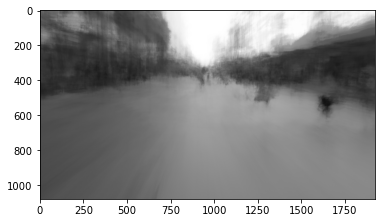

In [5]:
bg = get_background(frame,images)

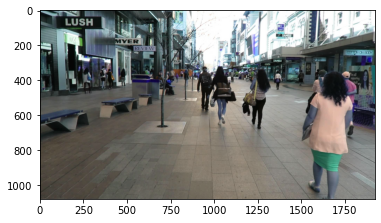

In [6]:
img_colour = cv2.imread(pwd+'/step_images/test/STEP-ICCV21-07/000001.jpg')
plt.imshow(img_colour)
img = cv2.cvtColor(img_colour,cv2.COLOR_BGR2GRAY)

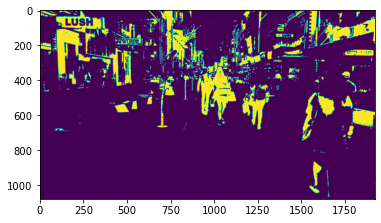

In [7]:
fg  = get_foreground_objects(img,bg,70)

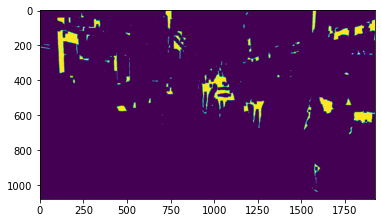

In [8]:
kernel = np.ones((5,5), np.uint8)
img_ = cv2.erode(fg, kernel, iterations=3)
#img_ = cv2.dilate(fg, kernel, iterations=1)
plt.imshow(img_)

In [12]:
def get_connected_components(res,connectivity):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(res, connectivity)
    sizes = stats[1:, -1]; nb_components = nb_components - 1
    img2 = np.zeros((output.shape),dtype = np.uint8)
    num_components = 0
    for i in range(0, nb_components):
        img2[output == i + 1] = 255
        num_components = num_components+1
    plt.imshow(img2)
    return nb_components, stats

In [13]:
threshold_total = 140 #this box's difference from the previous box, if it is less than this, it will be the same person
threshold_diff = 0.3 #the box's scale difference from the previous
c1 = (130,220,255)
c2 = (245,195,11)
c3 = (0,0,255)
text_font = 1.2
text_thick = 3 
area_threshold = 4500 ##less than this figure will discard the object
max_thre = 1800000
label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 
         '15', '16', '17', '18', '19', '20', '21','22', '23']
color = [(130,220,255), (250,135,115), (0,255,255), (102,205,170), (138,43,226), 
         (205,51,51), (102,205,0), (238,118,33), (193,255,193), (238,18,137), 
         (3,3,3), (247,247,247), (238,162,173), (255,153,18), (61,89,171), (128,138,135), (220,20,60),
        (0,100,0), (202,255,112), (154,50,205), (155,205,155), (148,0,211), (0,104,139)]
tree = [459, 0, 1074, 593, 325514]

def get_index_of_lab(prev, lab):
    for i in range(len(prev)):
        if prev[i][5] == lab:
            return i
    return 0

def diff_from_this_box(rect, noise, area):
    total = 0
    for i in range(4):
        total += abs(rect[i]-noise[i])
    diff = abs(area/noise[4])
    return total, diff

    
def draw_boxes(components,stats,original_img, prev, unique,r):
    
    this_stats = [] #return a new list stored label, prevous trajectory, group_flag
    
    #exist and apair share the same index
    exist = []
    apair = []
    group = 0 #number of people
    lab = 0  ##important index of label
    
    ##This stage is to extract the previous stored area and coordinate to compare whether it is similar
    # if this object is closed to prev determined by threshold, it will apply the same label as previous one
    if len(prev) != 0:
        count = []
        for this in range(components+1):
            x, y = stats[this,cv2.CC_STAT_LEFT], stats[this,cv2.CC_STAT_TOP]
            w, h = stats[this,cv2.CC_STAT_WIDTH], stats[this,cv2.CC_STAT_HEIGHT]
            area = stats[this,cv2.CC_STAT_AREA]
            rect = [x, y, w, h]
            totalt, difft = diff_from_this_box(rect, tree, area)
            ##Discard the noise like tree, non-person object
            if area < area_threshold or area > max_thre or (totalt < 540 and difft > 0.7):
                continue
            #traverse the prev list to compare and determine if it is a continous person
            for j in range(len(prev)):
                total, diff = diff_from_this_box(rect, prev[j], area)
                #and diff > 1-threshold_diff and diff < 1+threshold_diff 
                if total < threshold_total and prev[j][5] not in exist:    
                    exist.append(prev[j][5])
                    apair.append(area)
                    count.append(total)
                    break
                       
    ##draw the graph
    person_in_num = 0
    for i in range(components+1):
        group_flag = 0         
        flag = 0
        traj = []
        x, y = stats[i,cv2.CC_STAT_LEFT], stats[i,cv2.CC_STAT_TOP]
        w, h = stats[i,cv2.CC_STAT_WIDTH], stats[i,cv2.CC_STAT_HEIGHT]
        area = stats[i,cv2.CC_STAT_AREA]
        
        rect = [x, y, w, h]
        totalt, difft = diff_from_this_box(rect, tree, area)
        #Discard the noise like tree, non-person object 
        #or area > 100000
        if area < area_threshold or area > max_thre or (totalt < 540 and difft > 0.7):
            continue
            
        if len(prev) != 0:
            for it in range(len(apair)):
                if apair[it] == area:
                    lab = exist[it]
                    flag = 1
                
        if flag == 0:
            lab = 0
            while lab in exist:
                lab+=1
            exist.append(lab)
            unique+=1
                
        centroid = (int((rect[0]+rect[0]+rect[2])/2), int((rect[1]+rect[1]+rect[3])/2))
        if lab > 22:
            lab = 22
        if flag == 1 and len(prev) != 0 and lab < len(prev):
            j = get_index_of_lab(prev, lab)
            prev[j][6].append(centroid)
            traj = prev[j][6]
            size = len(prev[j][6])
            centr = prev[j][6]
            
            if size <= 1:
                cv2.circle(original_img, centroid, 5, color[lab], 2)
            else:
                for i in range(size-1):
                    cv2.line(original_img, centr[i], centr[i+1], color[lab], 4)
        else:
            traj = [centroid]
            cv2.circle(original_img, centroid, 5, color[lab], 2)
            
        if centroid[0] <= r[0] + r[2] and centroid[0] >= r[0] and centroid[1] <= r[1] + r[3] and centroid[1] >= r[1] and i!=0:
            person_in_num += 1
            
        cv2.rectangle(original_img, (r[0],r[1]), (r[0]+r[2],r[1]+r[3]), (255,255,0), 3)
        cv2.rectangle(original_img, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), color[lab], 3)
        cv2.putText(original_img, label[lab], (rect[0], rect[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color[lab], 4)
#         if rect[2]/rect[3] > 0.7:
#             if len(prev) == 0 or (len(prev) != 0 and j != 0 and prev[j][7] == 0):
#                 cv2.putText(original_img, "Form Group", (rect[0], rect[1]+30), cv2.FONT_HERSHEY_SIMPLEX, text_font, c3, text_thick)
#             group_flag = 1
#             group+=1
            
        if len(prev) == 0:
            lab+=1
        if flag == 0 and len(traj) <= 1:
            cv2.putText(original_img, "Enter", (rect[0], rect[1]+60), cv2.FONT_HERSHEY_SIMPLEX, text_font, c3, text_thick)
        
        if flag == 1 and (rect[0] < 100 and prev[j][0]-rect[0] > 0) or (1920-rect[0] < 100 and prev[j][0]-rect[0] < 0):
            cv2.putText(original_img, "Leave", (rect[0], rect[1]+60), cv2.FONT_HERSHEY_SIMPLEX, text_font, c3, text_thick)
            
        this_stats.append([x, y, w, h, area, lab, traj, group_flag])
       
    total_p = len(exist)
    cv2.putText(original_img, "Count of Unique pedestrain: {}".format(unique), (20, 40), cv2.FONT_HERSHEY_SIMPLEX, text_font, c1, text_thick)
    cv2.putText(original_img, "Total pedestrain: {}".format(total_p), (20, 90), cv2.FONT_HERSHEY_SIMPLEX, text_font, c1, text_thick)
    cv2.putText(original_img, "Pedestrain in group: {}".format(group), (20, 140), cv2.FONT_HERSHEY_SIMPLEX, text_font, c2, text_thick)
    cv2.putText(original_img, "Pedestrain alone: {}".format(total_p-group), (20, 190), cv2.FONT_HERSHEY_SIMPLEX, text_font, c2, text_thick)
    cv2.putText(original_img, "Pedestrain alone: {}".format(person_in_num), (20, 240), cv2.FONT_HERSHEY_SIMPLEX, text_font, (255,255,0), text_thick)
    
    cv2.imshow('test',original_img)
    cv2.waitKey()   
    cv2.destroyAllWindows()
    
    return original_img, this_stats, unique

(118,
 array([[      0,       0,    1920,    1080, 2002237],
        [    117,       0,       3,       5,      14],
        [    719,       0,      39,     109,    2219],
        [   1553,       0,      30,     129,    1986],
        [   1178,      14,      15,      13,      74],
        [    235,      16,      15,      26,     174],
        [      0,      22,       3,       3,       7],
        [    706,      29,       2,       1,       2],
        [    708,      36,       4,       5,      18],
        [     99,      43,      41,      40,    1009],
        [    164,      43,      11,      29,     262],
        [    199,      43,       2,       1,       2],
        [    224,      42,       6,       2,       7],
        [    278,      51,      67,      51,    1324],
        [   1881,      56,      39,      66,    1685],
        [    659,      59,       1,       2,       2],
        [   1871,      65,      17,       9,      88],
        [   1165,      84,       7,      20,      94],
    

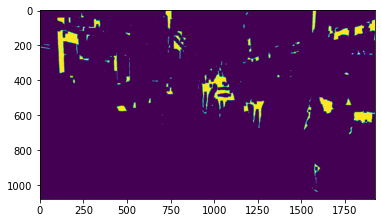

In [11]:
img_colour = cv2.imread(pwd+'/step_images/test/STEP-ICCV21-07/000001.jpg')
component,stat = get_connected_components(img_,2)
component,stat

In [14]:
def subtraction_algorithm(file, prev, uniq,r):
    #cotonur = cv2.imread(contour) ## label contour
    img_colour = cv2.imread(file) ##each original frame
    img = cv2.cvtColor(img_colour,cv2.COLOR_BGR2GRAY)
    
    fg  = get_foreground_objects(img,bg,20)
    kernel = np.ones((5,5), np.uint8)
    img_ = cv2.erode(fg, kernel, iterations=1)
    
    component,stat = get_connected_components(img_,2)
    #print(component)
    img_boxes, prev_stats, uniq = draw_boxes(component,stat,img_colour, prev, uniq,r)
    #cv2.imwrite('output/out{}'.filenames[-10:], img_boxes)
    return img_boxes, prev_stats, uniq

In [15]:
pwd = os.getcwd()
filename = glob.glob(pwd+'/step_images/test/STEP-ICCV21-01/*.jpg')
filenames = natsort.natsorted(filename)

In [16]:
filenames

['E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000001.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000002.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000003.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000004.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000005.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000006.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000007.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000008.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000009.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000010.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000011.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000012.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000013.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000014.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\000015.jpg',
 'E:\\jupyterdoc/step_images/test/STEP-ICCV21-01\\00001

In [ ]:
img_array = []
prev = []
uniq = 0
select_region = cv2.imread(filenames[0])
r = cv2.selectROI('roi',select_region , False, False)
for i in range(len(filenames)):
    img = cv2.imread(filenames[i])
    height, width, layers = img.shape
    size = (width,height)
    res, prev_stats, uni = subtraction_algorithm(filenames[i], prev, uniq,r)
    print("### Process with image {}".format(i))
    uniq = uni
    prev = prev_stats
    img_array.append(res)
cv2.waitKey()   
cv2.destroyAllWindows()


### Process with image 0
### Process with image 1


In [81]:
out = cv2.VideoWriter('project4.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()